In [1]:
import os
from matplotlib import pyplot as plt

import numpy as np

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

与SVM一样，决策树也是一种多功能的机器学习算法，它可以实现分类和回归任务，甚至是多输出任务。它们功能强大，能够拟合复杂的数据集。

决策树同时也是随机森林的基本组成部分，后者是现今最强大的机器学习算法之一。

在本章中，首先，讨论如何对决策树进行训练、可视化和预测；然后介绍Scikit-Learn的CART训练算法，讨论如何对决策树进行正则化并将其用于回归任务；最后，谈一谈决策树的部分限制。

## 决策树训练和可视化

要了解决策树，先构建一个决策树，看看它是如何做出预测的。下面的代码在鸢尾花数据集（见第4章）上训练了一个DecisionTreeClassifier：

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

# 如果修改random_state，将得不到下图结果
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

要将决策树可视化，首先，使用`export_graphviz()`方法输出一个图形定义文件，命名为iris_tree.dot：

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf,
                out_file=image_path("iris_tree.dot"),
                feature_names=iris.feature_names[2:],
                class_names=iris.target_names,
                rounded=True,
                filled=True)

然后，可以使用graphviz包 [1] 中的dot命令行工具将这个.dot文件转换为其他格式，例如PDF或PNG。下面这行命令将.dot文件转换为.png图像文件：

`apt install graphviz
dot -Tpng iris_tree.dot -o iris_tree.png`

第一个决策树如下图所示。

![iris_tree](images/VNote/20201016160244300_5588.png)

[1] graphviz是一个开源图形可视化软件包，可从http://wwwgraphviz.org/获取。

## 做出预测

看看上图树是如何做出预测的。如果找到了一朵鸢尾花，想要将其归类，那么从根节点（深度0，位于顶部）开始：这朵花的花瓣长度是否小于2.45厘米？如果是，则向下移动到根的左侧子节点（深度1，左）。本例中，这是一个叶节点（即没有任何子节点），所以它不再继续提出问题，你可以直接查看这个节点的预测类别，也就是说，决策树预测你的这朵花是Setosa鸢尾花（class=setosa）。

假设你又找到了一朵花，但是这次的花瓣长度大于0.8厘米。你必须移动到根节点的右侧子节点（深度1，右），该节点不是叶节点，所以它提出另一个问题：花瓣宽度是否小于1.75厘米？如果是，那这朵花最有可能是Versicolor鸢尾花（深度2，左）；如果不是，那就可能是Virginica鸢尾花（深度2，右）。就是这么简单。

> 决策树的特质之一就是它们需要的数据准备工作非常少。特别是，完全不需要进行特征缩放或集中。

节点的samples属性统计它应用的训练实例数量。例如，有100个训练实例的花瓣长度大于2.45厘米（深度1，右），其中54个花瓣宽度小于1.75厘米（深度2，左）。节点的value属性说明了该节点上每个类别的训练实例数量：例如，右下节点应用在0个Setosa鸢尾、1个Versicolor鸢尾和45个Virginica鸢尾实例上。最后，节点的gini属性衡量其不纯度（impurity）：如果应用的所有训练实例都属于同一个类别，那么节点就是“纯”的（gini=0）。例如，深度1左侧节点仅应用于Setosa鸢尾花训练实例，所以它就是纯的，并且gini值为0。公式6-1说明了第i个节点的基尼系数$G_i$的计算方式。例如，深度2左侧节点，基尼系数等于$1-(\frac{0}{54})^2-(\frac{49}{54})^2-(\frac{5}{54})^2 \approx 0.168$。稍后还将介绍另一种不纯度的衡量方法。

公式6-1：基尼不纯度

$$
G_i = 1 - \sum_{k=1}^n p_{i,k}^2 \tag{6-1}
$$

> $p_{ik}$ 是第$i$个节点上，类别为$k$的训练实例占比。

> Scikit-Learn使用的是CART算法，该算法仅生成二叉树：非叶节点永远只有两个子节点（即问题答案仅有是或否）。但是，其他算法，比如ID3生成的决策树，其节点可以拥有两个以上的子节点。

下图显示了决策树的决策边界。加粗直线表示根节点（深度0）的决策边界：花瓣长度=2.45厘米。因为左侧区域是纯的（只有Setosa鸢尾花），所以它不可再分。但是右侧区域是不纯的，所以深度1右侧的节点在花瓣宽度=1.75厘米处（虚线所示）再次分裂。因为这里最大深度max_depth设置为2，所以决策树在此停止。但是如果你将max_depth设置为3，那么两个深度为2的节点将各自再产生一条决策边界（点线所示）。

<Figure size 576x288 with 0 Axes>

Text(1.4, 1.0, 'Depth=0')

Text(3.2, 1.8, 'Depth=1')

Text(4.05, 0.5, '(Depth=2)')

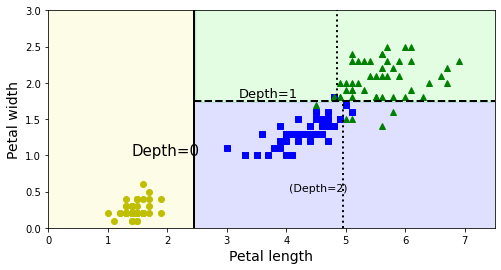

In [4]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

#save_fig("decision_tree_decision_boundaries_plot")
plt.show()

决策树是非常直观的，它们的决策也很容易解释，这类模型通常被称为白盒模型。与之相反的，稍后将会看到，随机森林或是神经网络被认为是一种黑盒模型。它们能做出很棒的预测，也可以轻松检查它们在做出预测时执行的计算，然而，通常很难解释清楚它们为什么做出这样的预测。

## 估算类别概率

决策树同样可以估算某个实例属于特定类别k的概率：首先，跟随决策树找到该实例的叶节点，然后返回该节点中类别k的训练实例占比。例如，假设发现一朵花，其花瓣长5厘米，宽1.5厘米。相应的叶节点为深度2左侧节点，因此决策树输出如下概率：Setosa鸢尾花，0%（0/54）；Versicolor鸢尾花，90.7%（49/54）；Virginica鸢尾花，9.3%（5/54）。当然，如果要求它预测类别，那么它应该输出Versicolor鸢尾花（类别1），因为它的概率最高。

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

注意，上图右下矩形中任意点的估算概率都是相同的——比如，如果花瓣长6厘米，宽1.5厘米，概率还是一样（虽然看起来，这时最大的可能应该是Virginica鸢尾花）。

## CART训练算法

Scikit-Learn使用的是分类与回归树（Classification And Regression Tree，简称CART）算法来训练决策树（也叫作“生长”树）。想法非常简单：首先，使用单个特征$k$和阈值$t_k$ （例如，花瓣长度$\leq$2.45厘米）将训练集分成两个子集。$k$和阈值$t_k$怎么选择？答案是产生出最纯子集（受其大小加权）的$k$和$t_k$就是经算法搜索确定的$(t, t_k)$。算法尝试最小化的成本函数为公式6-2。

$$
J(k,t_k) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right} \tag{6-2} \label{6-2}
$$

其中$G_{left/right}$指衡量左右子集的不纯度；$m_{left/right}$衡量

一旦成功将训练集一分为二，它将使用相同的逻辑，继续分裂子集，然后是子集的子集，依次循环递进。直到抵达最大深度（由超参数`max_depth`控制），或是再也找不到能够降低不纯度的分裂，它才会停止。还有一些超参数（稍后介绍）可以用来控制附加的停止条件（`min_samples_split`、`min_samples_leaf`、`min_weight_fraction_leaf`及`max_leaf_nodes`）。

> CART是一种贪婪算法：从顶层开始搜索最优分裂，然后每层重复这个过程。几层分裂之后，它并不会检视这个分裂的不纯度是否为可能的最低值。贪婪算法通常会产生一个相当不错的解，但是不能保证是最优解。

而不幸的是，寻找最优树是一个已知的NP完全问题： [1] 需要的时间是$O(\exp(m))$，所以即使是很小的训练集，也相当棘手。这就是为什么必须接受一个“相当不错”的解。

[1] P就是能在多项式时间内解决的问题集。NP是能在多项式时间内验证解正确与否的问题集。如果一个问题L是NP-Hard问题，那么任意一个NP问题都可以在多项式时间内被规约成这个L问题。而NP完全问题即是NP问题，又是NP-Hard问题。有一个数学开放问题，即P是否等于NP？如果$P \neq NP$（看起来很可能如此），那么对于任何NP完全问题，将不存在多项式算法（可能量子计算机除外）。

## 计算复杂度

进行`预测`需要从根到叶遍历决策树。通常来说，决策树大致平衡，因此遍历决策树需要经历大约$O(log_2(m))$个节点。而每个节点只需要检查一个特征值，所以总体预测复杂度也只是$O(log_2(m))$，与特征数量无关。如此，即便是处理大型数据集，预测也很快。

但是，`训练`时在每一个节点，算法都需要在所有样本上比较所有特征（如果设置了`max_features`会少一些）。这导致训练的复杂度为$O(n \times m \log(m))$。对于小型训练集（几千个实例以内），Scikit-Learn可以通过对数据预处理（设置`presort=True`）来加快训练，但是对于较大训练集而言，可能会减慢训练的速度。

## 基尼不纯度还是信息熵

默认使用的是`基尼不纯度`来进行测量，但是，可以将超参数`criterion`设置为"entropy"来选择`信息熵`作为不纯度的测量方式。熵的概念源于热力学，是一种分子混乱程度的度量：如果分子保持静止和良序，则熵接近于零。后来这个概念传播到各个领域，其中包括香农的信息理论，它衡量的是一条信息的平均信息内容： [1] 如果所有的信息都相同，则熵为零。在机器学习中，它也经常被用作一种不纯度的测量方式：如果数据集中仅包含一个类别的实例，其熵为零。公式6-3显示了第$i$个节点的熵值的计算方式。例如，图6-1中深度2左侧节点的熵值等于$-\frac{49}{54}\log(\frac{49}{54})-\frac{5}{54}\log(\frac{5}{54}) \approx 0.31$。

$$
H_i = -\sum_{k=1} ^ n p_{i,k}\log(p_{i,k}) \\
p_{i,k} \neq 0 \tag{6-3} \label{6-3}
$$


那么到底应该使用基尼不纯度还是信息熵呢？其实，大多数情况下，它们并没有什么大的不同，产生的树都很相似。基尼不纯度的计算速度略微快一些，所以它是个不错的默认选择。它们的不同在于，基尼不纯度倾向于从树枝中分裂出最常见的类别，而信息熵则倾向于生产更平衡的树。 [2]

[1] 熵值的减少通常被称为信息增益。

[2] 更多详情可参阅Sebastian Raschka的有趣分析(https://sebastianraschka.com/faq/docs/decision-treebinary.html)。

## 正则化超参数

决策树极少对训练数据做出假设（比如线性模型就正好相反，它显然假设数据是线性的）。如果不加以限制，树的结构将跟随训练集变化，严密拟合，并且很可能过度拟合。这种模型通常被称为`非参数模型`，这不是说它不包含任何参数（事实上它通常有很多参数），而是指在**训练之前没有确定参数的数量**，导致模型结构自由而紧密地贴近数据。相应的参数模型，比如线性模型，则有预先设定好的一部分参数，因此其自由度受限，从而降低了过度拟合的风险（但是增加了拟合不足的风险）。

为避免过度拟合，需要在训练过程中降低决策树的自由度。这个过程被称为正则化。正则化超参数的选择取决于你所使用的模型，但是通常来说，至少可以限制决策树的最大深度。在Scikit-Learn中，这由超参数`max_depth`控制（默认值为None，意味着无限制）。减小`max_depth`可使模型正则化，从而降低过度拟合的风险。

`DecisionTreeClassifier`类还有一些其他的参数，同样可以限制决策树的形状：`min_samples_split`（分裂前节点必须有的最小样本数），`min_samples_leaf`（叶节点必须有的最小样本数量），`min_weight_fraction_leaf`（跟`min_samples_leaf`一样，但表现为加权实例总数的占比），`max_leaf_nodes`（最大叶节点数量），以及`max_features`（分裂每个节点评估的最大特征数量）。增大超参数`min_*`或是减小`max_*`将使模型正则化。

> 还可以先不加约束地训练模型，然后再对不必要的节点进行剪枝（删除）。如果一个节点的子节点全部为叶节点，则该节点可被认为不必要，除非它所表示的纯度提升有重要的统计意义。标准统计测试，比如 $\chi^2$ 测试，是用来估算“提升纯粹是出于偶然”（被称为虚假设）的概率。如果这个概率（称之为$p$值）高于一个给定阈值（通常是5%，由超参数控制），那么这个节点可被认为不必要，其子节点可被删除。直到所有不必要的节点都被删除，剪枝过程结束。

下图显示了在卫星数据集（见第5章介绍）上训练的两个决策树。左图使用默认参数（即无约束）来训练决策树，右图的决策树应用`min_samples_leaf=4`进行训练。很明显，左图模型过度拟合，右图的泛化效果更佳。

DecisionTreeClassifier(random_state=42)

DecisionTreeClassifier(min_samples_leaf=4, random_state=42)

<Figure size 792x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'No restrictions')

<AxesSubplot:>

Text(0.5, 1.0, 'min_samples_leaf = 4')

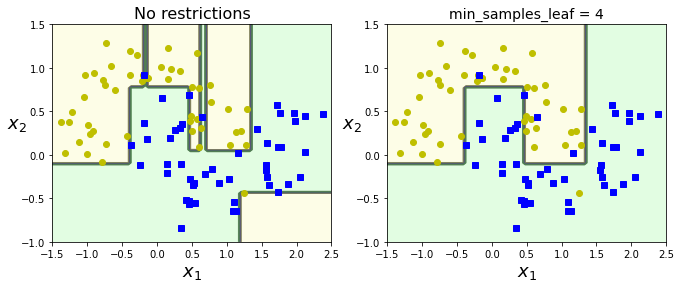

In [7]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

#save_fig("min_samples_leaf_plot")
plt.show()

## 回归

决策树也可以执行回归任务。用Scikit_Learn的`DecisionTreeRegressor`来构建一个回归树，在一个带噪声的二次数据集上进行训练，其中`max_depth=2`：

In [8]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [10]:
export_graphviz(
        tree_reg,
        out_file=image_path("regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

结果树如下图所示。

![regression_tree](images/VNote/20201019145147020_10031.png)

这棵树看起来跟之前建立的分类树很相似。主要差别在于，每个节点上不再是预测一个类别而是预测一个值。例如，如果你想要对一个$x_1 =0.6$的新实例进行预测，那么从根节点开始遍历，最后到达预测$value=0.1106$的叶节点。这个预测结果其实就是与这个叶节点关联的110个实例的平均目标值。在这110个实例上，预测产生的均方误差（MSE）等于0.0151。

图6-5的左侧显示了该模型的预测。如果设置`max_depth=3`，将得到如右图所示的预测。注意看，每个区域的预测值永远等于该区域内实例的目标平均值。算法分裂每个区域的方法，就是使最多的训练实例尽可能接近这个预测值。

CART算法的工作原理跟前面介绍的大致相同，唯一不同在于，它分裂训练集的方式不是最小化不纯度，而是最小化MSE。公式6-4显示了算法尝试最小化的成本函数。

$$
J(k,t_k) = \frac{m_{left}}{m}MSE_{left} + \frac{m_{right}}{m}MSE_{right} \tag{6-2} \label{6-2}
$$

DecisionTreeRegressor(max_depth=2, random_state=42)

DecisionTreeRegressor(max_depth=3, random_state=42)

<Figure size 792x288 with 0 Axes>

<AxesSubplot:>

Text(0.21, 0.65, 'Depth=0')

Text(0.01, 0.2, 'Depth=1')

Text(0.65, 0.8, 'Depth=1')

Text(0.5, 1.0, 'max_depth=2')

<AxesSubplot:>

Text(0.3, 0.5, 'Depth=2')

Text(0.5, 1.0, 'max_depth=3')

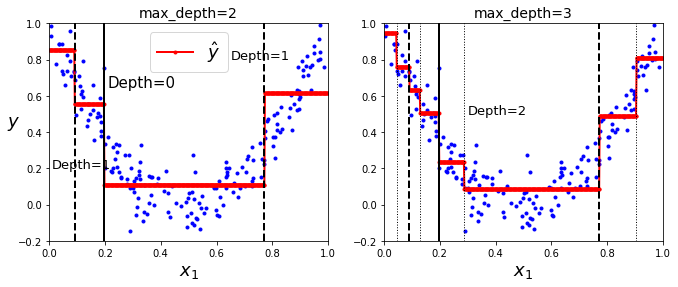

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

#save_fig("tree_regression_plot")
plt.show()

与分类任务一样，决策树在处理回归任务时也很容易过度拟合。如果没有任何正则化（即使用默认超参数），将得到下图左侧所示的预测结果，这显然对训练集严重过度拟合。只需要设置`min_samples_leaf=10`，就能得到一个看起来合理得多的模型，下图右图所示。

DecisionTreeRegressor(random_state=42)

DecisionTreeRegressor(min_samples_leaf=10, random_state=42)

<Figure size 792x288 with 0 Axes>

<AxesSubplot:>

(0.0, 1.0, -0.2, 1.1)

Text(0.5, 0, '$x_1$')

Text(0, 0.5, '$y$')

Text(0.5, 1.0, 'No restrictions')

<AxesSubplot:>

(0.0, 1.0, -0.2, 1.1)

Text(0.5, 0, '$x_1$')

Text(0.5, 1.0, 'min_samples_leaf=10')

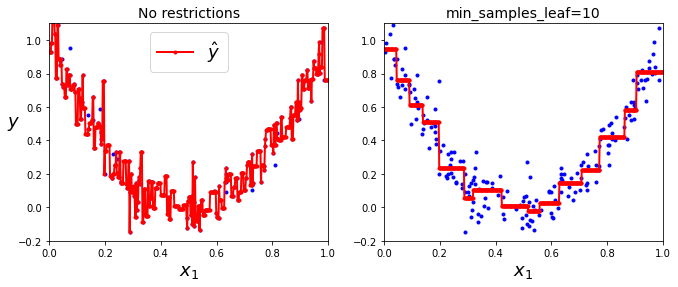

In [12]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

#save_fig("tree_regression_regularization_plot")
plt.show()

## 不稳定性

希望现在，选择决策树已有充足理由：它们很容易理解和解释，使用简单，功能全面并且十分强大。但是，它们确实也有一些限制。首先，决策树青睐正交的决策边界（所有的分裂都与轴线垂直），这导致它们对训练集的旋转非常敏感。

例如，下图显示了一个简单的线性可分离数据集：左图里，决策树可以很轻松分裂；而到了右边，数据集旋转45°后，决策边界产生了不必要的卷曲。虽然两个模型都看似完美拟合训练集，但是右侧模型很可能泛化不佳。限制这种问题的方法之一是使用`PCA`（参见第8章），让训练数据定位在一个更好的方向上。

DecisionTreeClassifier(random_state=42)

DecisionTreeClassifier(random_state=42)

<Figure size 792x288 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

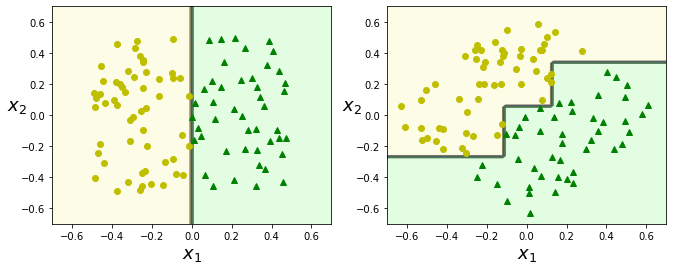

In [13]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

#save_fig("sensitivity_to_rotation_plot")
plt.show()

更概括地说，决策树的主要问题是它们对训练数据中的小变化非常敏感。例如，从鸢尾花数据集中移除花瓣最宽的Versicolor鸢尾花（花瓣长4.8厘米，宽1.8厘米），然后重新训练一个决策树，你可能得到如图6-8所示的模型。这跟之前图6-2的决策树看起来截然不同。事实上，由于Scikit-Learn所使用的算法是随机的， [1] 即使是在相同的训练数据上，你也可能得到完全不同的模型（除非你对超参数random_state进行设置）。

In [14]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris-Versicolor flower

array([[4.8, 1.8]])

In [15]:
# 找到花瓣最宽的数据
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)]
# 去除最宽的数据
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

array([[4.8, 1.8]])

DecisionTreeClassifier(max_depth=2, random_state=40)

<Figure size 576x288 with 0 Axes>

Text(1.0, 0.9, 'Depth=0')

Text(1.0, 1.8, 'Depth=1')

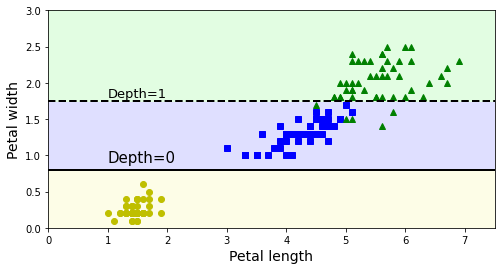

In [16]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

#save_fig("decision_tree_instability_plot")
plt.show()

在下一章中，随机森林通过对许多树的预测进行平均，可以限制这种不稳定性。

[1] 每个节点随机选择特征集进行评估。

## 练习

1.如果训练集有100万个实例，训练决策树（无约束）大致的深度是多少？

$\log_2(1000000) \approx 20$

2.通常来说，子节点的基尼不纯度是高于还是低于其父节点？是通常更高/更低？还是永远更高/更低？

子节点更低；通常更低。

3.如果决策树过度拟合训练集，减少max_depth是否为一个好主意？

**可能**是个好主意，但是可能会限制模型，使其正则化

4.如果决策树对训练集拟合不足，尝试缩放输入特征是否为一个好主意？

不是，对模型缩放不敏感。

5.如果在包含100万个实例的训练集上训练决策树需要一个小时，那么在包含1000万个实例的训练集上训练决策树，大概需要多长时间？

计算复杂度：𝑂(𝑛×𝑚log(𝑚))；10倍的数据`1*10*log(10)`

6.如果训练集包含100000个实例，设置presort=True可以加快训练么？

只有当数据集小于数千个实例时，预处理训练集才可以加速训练。如果包含100000个实例，设置presort=True会显著减慢训练。

7.为卫星数据集训练并微调一个决策树。

a.使用make_moons（n_samples=10000，noise=0.4）生成一个卫星数据集。

In [17]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=55)

b.使用train_test_split（）拆分训练集和测试集。

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

c.使用交叉验证的网格搜索（在GridSearchCV的帮助下）为DecisionTree-Classifier找到适合的超参数。提示：尝试max_leaf_nodes的多种值。

In [19]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=55), params, n_jobs=-1, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:    2.9s finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=55), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [20]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

d.使用超参数对整个训练集进行训练，并测量模型在测试集上的性能。你应该得到约85%到87%的准确率。

In [21]:
from sklearn.metrics import accuracy_score
y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_pred, y_test)

0.845

8.种植一片森林。

a.继续之前的练习，生产1000个训练集子集，每个子集包含随机挑选的100个实例。提示：使用Scikit-Learn的ShuffleSplit来实现。

In [22]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=55)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

b.使用前面得到的最佳超参数值，在每个子集上训练一个决策树。在测试集上评估这1000个决策树。因为训练集更小，所以这些决策树的表现可能比第一个决策树要差一些，只能达到约80%的准确率。

In [23]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train,)
    
    y_pred = tree.predict(X_test,)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

DecisionTreeClassifier(max_leaf_nodes=17, random_state=55)

0.7898019999999999

c.见证奇迹的时刻到了。用每个测试集实例，生成1000个决策树的预测，然后仅保留次数最频繁的预测（可以使用SciPy的mode（）函数）。这样你在测试集上可获得大多数投票的预测结果。

In [24]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [25]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

d.评估测试集上的这些预测，你得到的准确率应该比第一个模型更高（高出0.5%～1.5%）。恭喜，你已经训练出了一个随机森林分类器！

In [26]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8556666666666667